# Inbalanced learn examples

 Using the module inbalanced learn to balanced our dataset (increase positives)
 To install "pip install -U imbalanced-learn" or "conda install -c glemaitre imbalanced-learn"

In [1]:
import imblearn
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets, preprocessing
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_curve, auc, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
import bisect
from immas import classification
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [2]:
SVM_baseline = []
FROC_baseline = []
SVM_resampled = []
FROC_resampled = []
labels = []

In [3]:
for i in range (0,10):
    # Loading of data and splitting in groups according to images
    # Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

    # Load the dataset and groups by image filename
    filename = "C:\\AIA-2018\\examples\\feature-tables\\train-data_1527086478.csv"
    dataset_df1, dataset_df2 = classification.load_features_data(filename)

    # Conversion from pandas dataframe to numpy array
    # Keeps all the features from the original csv file
    Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
    Target  = dataset_df1['class_id']
    dataset01_data = Feature.as_matrix()
    dataset01_labels = Target.as_matrix()

    Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
    Target  = dataset_df2['class_id']
    dataset02_data = Feature.as_matrix()
    dataset02_labels = Target.as_matrix()

    # Shuflles the datasets and creates one variable with labels for all the samples
    dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
    dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
    all_data = np.vstack((dataset01_data, dataset02_data))
    all_labels = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

    # Data standardization for each dataset (two methods)
    dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
    dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
    all_data = preprocessing.StandardScaler().fit_transform(all_data)
    #dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
    #dataset02_data = preprocessing.robust_scale(dataset02_data)

    # Concatenates data and labels of dataset01 into one array
    dataset01 = np.zeros((dataset01_data.shape[0],dataset01_data.shape[1]+1));
    dataset01[:,:-1] = dataset01_data
    dataset01[:,-1] = dataset01_labels

    # Concatenates data and labels of dataset02 into one array
    dataset02 = np.zeros((dataset02_data.shape[0],dataset02_data.shape[1]+1));
    dataset02[:,:-1] = dataset02_data
    dataset02[:,-1] = dataset02_labels
    ROC_labels = np.concatenate((dataset02_labels,dataset01_labels))

    # Running with parameters otpimized for features without LBP (oversampling)
    oversampling_kernel = SMOTE(random_state=0,k_neighbors=10, m_neighbors=5,kind = 'svm')
    SVM_osprob,_,FROC_os,_,_ = classification.optimal_oversampling_SVM (dataset01, dataset02, oversampling_kernel, kernel='rbf', features='all_except_LBP',show_plot='no')
    SVM_prob,_,FROC_base,_,_ = classification.run_SVM (dataset01, dataset02, kernel='rbf', features='all_except_LBP',show_plot='no')
    SVM_baseline.append(SVM_prob)
    FROC_baseline.append(FROC_base)
    SVM_resampled.append(SVM_osprob)
    FROC_resampled.append(FROC_os)
    labels.append(ROC_labels)

Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3234
Number of regions in dataset 02: 3142
Area under the original ROC curve for our classifier: 0.93
Partial area under the FROC curve for FPPI between 0 and 1: 0.52380
(3142, 2)
(3142, 25)
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56770
Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3078
Number of regions in dataset 02: 3298
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.54159
(3298, 2)
(3298, 25)
Area under the original ROC curve for our classifier: 0.94
Partial area under the FROC curve for FPPI between 0 and 1: 0.56248
Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3088
Number of regions in

In [4]:
SVM_baseline = np.vstack(SVM_baseline)
SVM_resampled = np.vstack(SVM_resampled)
labels = np.concatenate(labels)
baseline_mean = np.mean(FROC_baseline)
baseline_std = np.std(FROC_baseline)
resampled_mean = np.mean(FROC_resampled)
resampled_std = np.std(FROC_resampled)

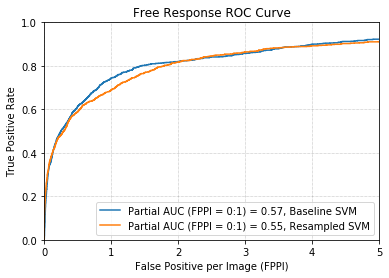

Baseline SVM mean:  0.5711876988335101 Standard deviation:  0.011667263811245896
Resampled SVM mean:  0.5520890774125132 Standard deviation:  0.018744516772438508


In [5]:
classification.get_roc([labels,labels], [SVM_baseline,SVM_resampled],leg_lbs=['Baseline SVM','Resampled SVM'])
print('Baseline SVM mean: ', baseline_mean, 'Standard deviation: ', baseline_std)
print('Resampled SVM mean: ', resampled_mean, 'Standard deviation: ', resampled_std)